In [219]:
%%script false --no-raise-error
%%sh
export ZARR_V3_EXPERIMENTAL_API=1

c.Spawner.cpu_limit = 1
c.Spawner.mem_limit = '2G'

In [220]:
%%time
# Create Testing Dataset, Change Parameters to vary size 
import xarray as xr
import numpy as np

u = np.random.rand(1_000_000, 10, 10, 1)
v = np.random.rand(1_000_000, 10, 10, 1)
w = np.random.rand(1_000_000, 10, 10, 1)
x = np.random.rand(1_000_000, 10, 10, 1)
y = np.random.rand(1_000_000, 10, 10, 1)
z = np.random.rand(1_000_000, 10, 10, 1)

ds = xr.Dataset(data_vars=dict(
                            u=(["1","2","3","4"], u),
                            v=(["1","2","3","4"], v),
                            w=(["1","2","3","4"], w),
                            x=(["1","2","3","4"], x),
                            y=(["1","2","3","4"], y),
                            z=(["1","2","3","4"], z)
                            ))

ds.to_zarr("data/test_dataset.zarr", mode="w", zarr_format=2)

ds.to_netcdf("data/test_dataset.nc", mode="w", format="NETCDF4", engine="netcdf4")

ds.to_netcdf("data/test_dataset.h5", mode="w", engine="h5netcdf")


PermissionError: [Errno 13] Permission denied: '/home/test/dkrz_dev/data/test_dataset.nc'

In [221]:
#dataset creation for plotting

zarr_op_time = []
netcdf4_op_time = []
hdf5_op_time = []

zarr_read_time = []
netcdf4_read_time = []
hdf5_read_time = []

zarr_write_time = []
netcdf4_write_time = []
hdf5_write_time = []

In [222]:
%%time
#Open benchmark zarr
import zarr
import time

for i in range(10000):
    start_time = time.time()
    ds_zarr = zarr.open(store="data/test_dataset.zarr",mode="r+" ,zarr_version=2)
    zarr_op_time.append(time.time() - start_time) 
     


CPU times: user 253 ms, sys: 88.1 ms, total: 341 ms
Wall time: 307 ms


In [223]:
%%prun -r -D data/profile_open_zarr -q
ds_zarr = zarr.open(store="data/test_dataset.zarr",mode="r+" ,zarr_version=2)

 
*** Profile stats marshalled to file 'data/profile_open_zarr'.


In [224]:
%%sh 
gprof2dot -f pstats data/profile_open_zarr | dot -Tpng -o output.png

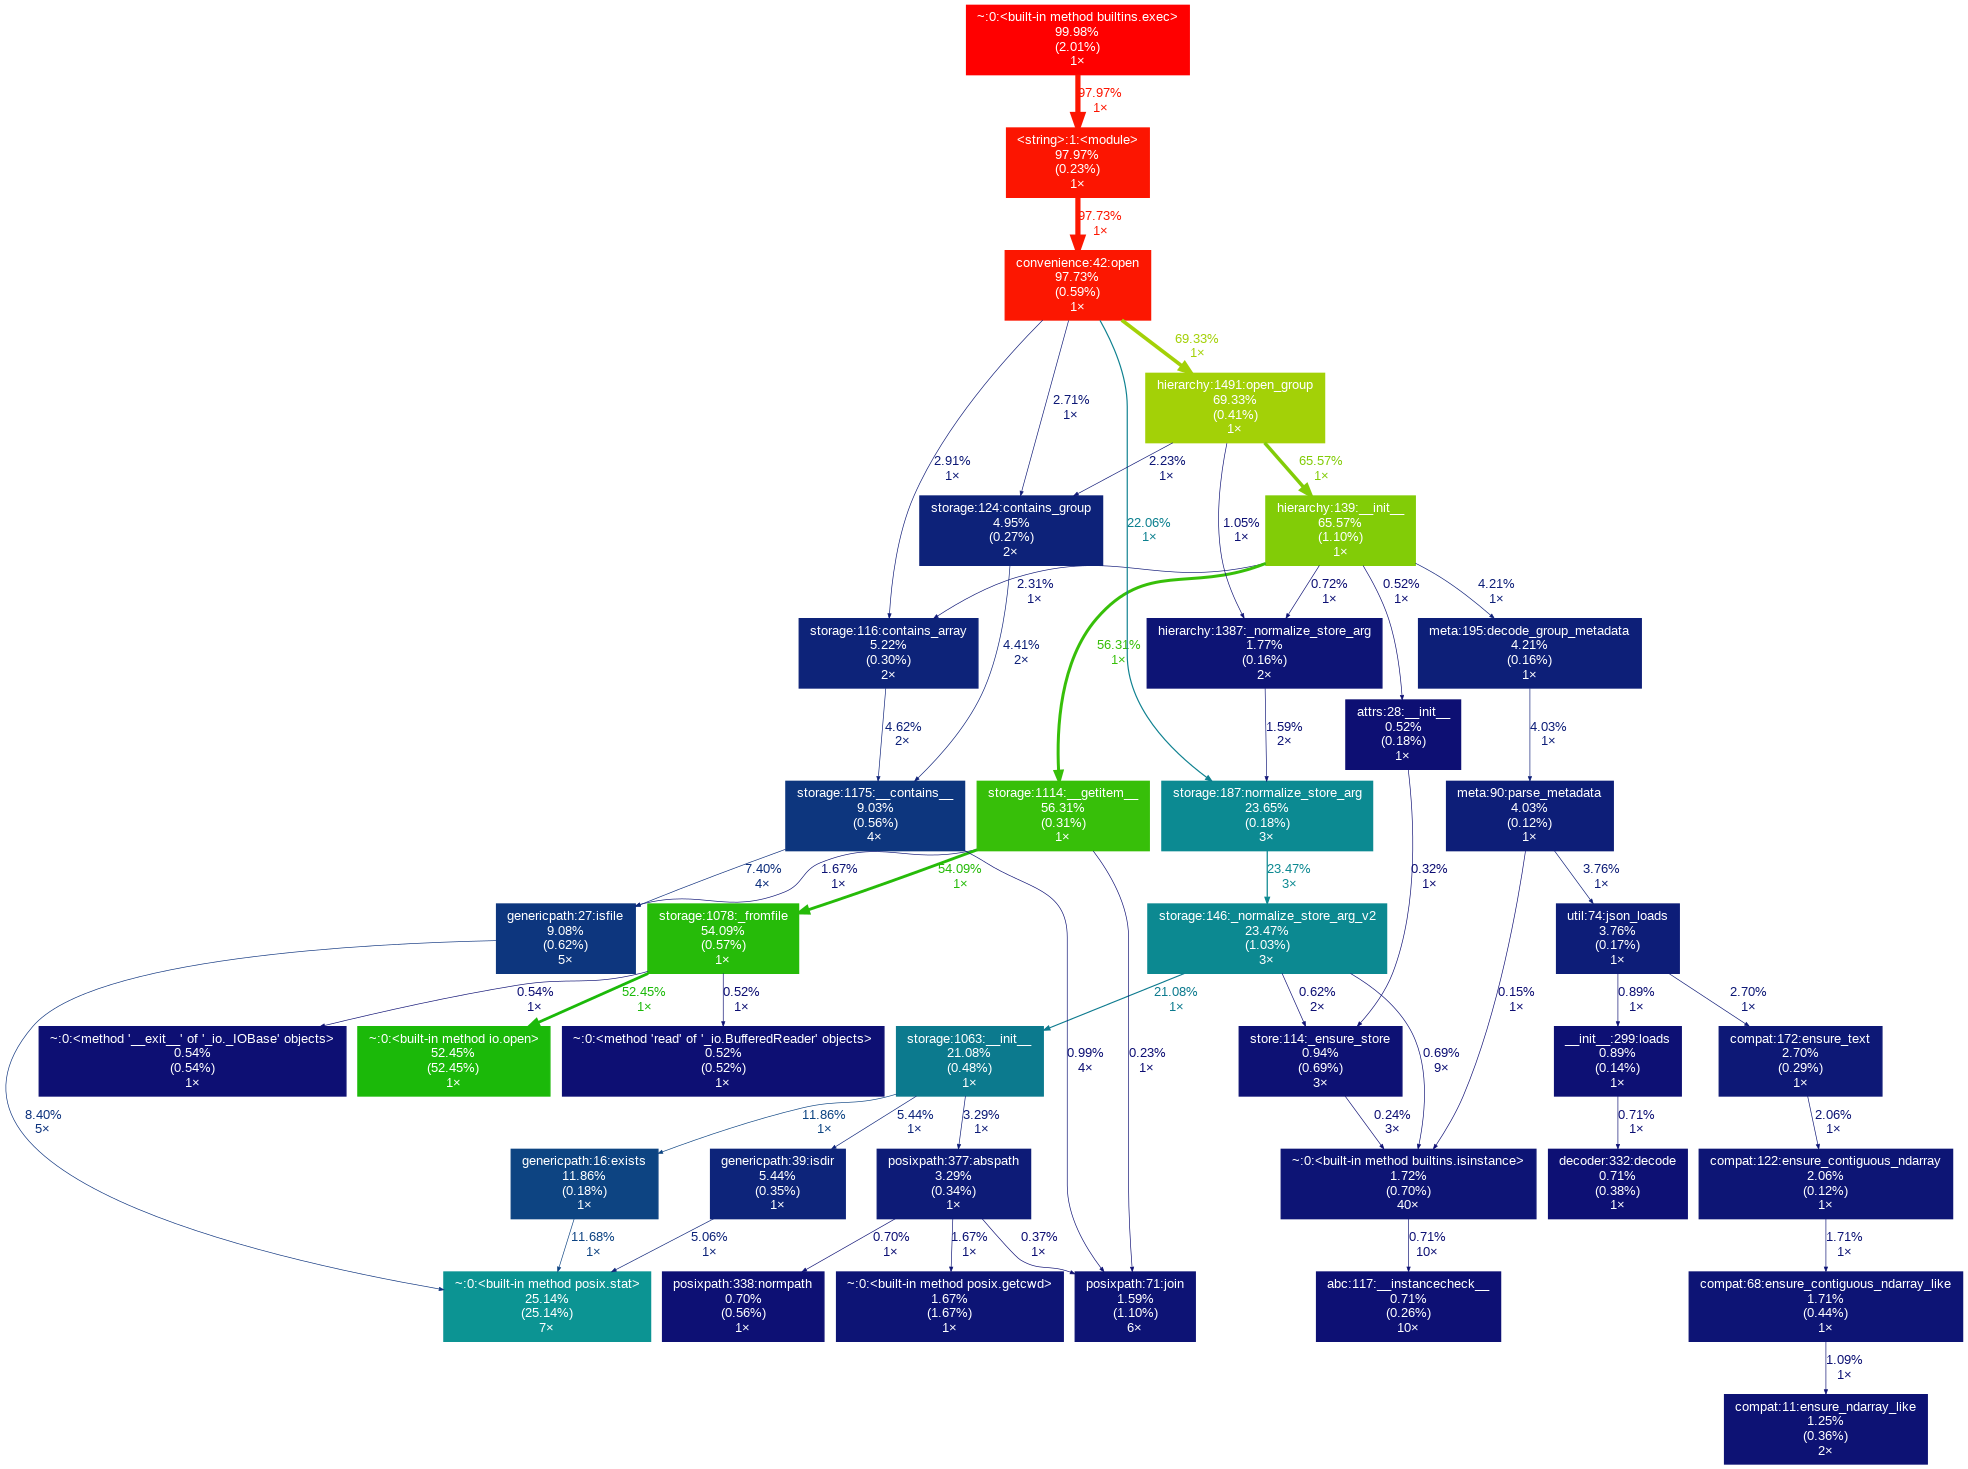

In [225]:
from IPython.display import Image

Image("output.png")

In [226]:
%%time 
#Read benchmark zarr
import time
import numpy as np
import zarr

ds_zarr = zarr.open(store="data/test_dataset.zarr",mode="r+" ,zarr_version=2)

for i in range(1000):
    #print(f"Currently in i: {i}")
    val_picked = np.random.randint(low=0, high=1000000-1)
    tmp=0
    
    start_time = time.time()
    tmp = ds_zarr["x"][val_picked]
    zarr_read_time.append(time.time() - start_time) 
    
    #print(f"Current val read at {val_picked}: {tmp}")
    

CPU times: user 3.42 s, sys: 3.65 s, total: 7.07 s
Wall time: 6.36 s


In [227]:
%%time 
#Write benchmark zarr
import time
import numpy as np
import zarr

ds_zarr = zarr.open(store="data/test_dataset.zarr",mode="r+" ,zarr_version=2)

for i in range(1_000):
    #print(f"Currently in i: {i}")
    val_picked = np.random.randint(low=0, high=1_000_000-1)
    tmp=0
    prev = ds_zarr["x"][val_picked]
    curr = ds_zarr["x"][val_picked]

    #print(f"prev item at {val_picked} is {type(prev)} and curr item at {val_picked} is {type(curr)}, both are the same : {(prev == curr).all()}")
    
    start_time = time.time()
    ds_zarr["x"][val_picked] = np.random.rand(10,10,1)
    zarr_write_time.append(time.time() - start_time) 
    
    curr = ds_zarr["x"][val_picked]
    #print(f"Current val read at {val_picked}: {(prev == curr).all()}")
    

CPU times: user 24.6 s, sys: 47.9 s, total: 1min 12s
Wall time: 1min 12s


In [228]:
%%time 
#Open Benchmark netcdf4
import time
import netCDF4

for i in range(1_0000):
    start_time = time.time()
    ds_netcdf4 = netCDF4.Dataset("data/test_dataset.nc", mode="r+", format="NETCDF4")
    netcdf4_op_time.append(time.time() - start_time)

CPU times: user 12.5 s, sys: 1.69 s, total: 14.2 s
Wall time: 12.8 s


In [229]:
%%prun -r -D data/profile_open_netcdf4 -q
ds_netcdf4 = netCDF4.Dataset("data/test_dataset.nc", mode="r+", format="NETCDF4")

 
*** Profile stats marshalled to file 'data/profile_open_netcdf4'.


In [230]:
%%sh 
gprof2dot -f pstats data/profile_open_netcdf4 | dot -Tpng -o output.png

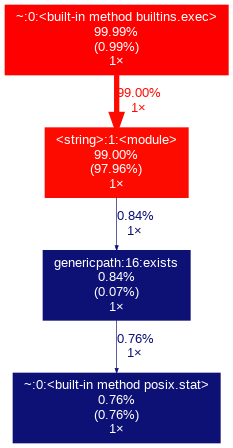

In [231]:
from IPython.display import Image

Image("output.png")

In [232]:
%%time
#Read Benchmark netcdf4
import time
import numpy as np
import netCDF4

ds_netcdf4 = netCDF4.Dataset("data/test_dataset.nc", mode="r+", format="NETCDF4")
    
    
for i in range(1000):
    #print(f"Currently in i: {i}")
        
    val_picked = np.random.randint(low=0, high=1_000_000-1)
    tmp=0
        
    start_time = time.time()
    tmp = ds_netcdf4.variables["x"][val_picked]
    netcdf4_read_time.append(time.time() - start_time)
        
    #print(f"Current val read at {val_picked}: {tmp}")

CPU times: user 118 ms, sys: 54.5 ms, total: 173 ms
Wall time: 506 ms


In [233]:
%%time
#Write Benchmark netcdf4
import time
import numpy as np
import netCDF4

ds_netcdf4 = netCDF4.Dataset("data/test_dataset.nc", mode="r+", format="NETCDF4")
    
for i in range(1000):
    #print(f"Currently in i: {i}")
        
    val_picked = np.random.randint(low=0, high=1_000_000-1)
    tmp = 0
    prev = ds_netcdf4.variables["x"][val_picked]
    curr = ds_netcdf4.variables["x"][val_picked]

    #print(f"prev item at {val_picked} is {type(prev)} and curr item at {val_picked} is {type(curr)}, both are the same : {(prev == curr).all()}")
        
    start_time = time.time()
    ds_netcdf4.variables["x"][val_picked] = np.random.rand(10,10,1)
    netcdf4_write_time.append(time.time() - start_time)
    
    curr = ds_zarr["x"][val_picked]
    #print(f"Current val read at {val_picked}: {(prev == curr).all()}")

CPU times: user 3.89 s, sys: 13.6 s, total: 17.5 s
Wall time: 19.6 s


In [234]:
%%time
#Open Benchmark hdf5
import h5py
import time

for i in range(10_000):
    start_time = time.time()
    ds_hdf5 = h5py.File("data/test_dataset.h5", mode="r+")
    hdf5_op_time.append(time.time() - start_time)

CPU times: user 108 ms, sys: 30.4 ms, total: 138 ms
Wall time: 124 ms


In [235]:
%%prun -r -D data/profile_open_hdf5 -q

ds_hdf5 = h5py.File("data/test_dataset.h5", mode="r+")

 
*** Profile stats marshalled to file 'data/profile_open_hdf5'.


In [236]:
%%sh 
gprof2dot -f pstats data/profile_open_hdf5 | dot -Tpng -o output.png

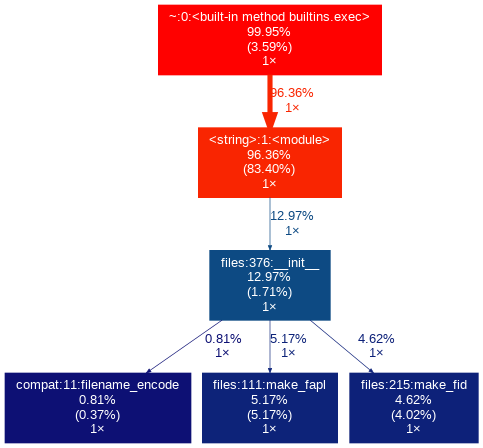

In [237]:
from IPython.display import Image

Image("output.png")

In [238]:
%%time
#Read Benchmark hdf5
import time
import numpy as np
import h5py

ds_hdf5 = h5py.File("data/test_dataset.h5", mode="r+")
    
for i in range(1_000):
    #print(f"Currently in i: {i}")
        
    val_picked = np.random.randint(low=0, high=1_000_000-1)
    tmp=0
        
    start_time = time.time()
    tmp = ds_hdf5.get("x")[val_picked]
    hdf5_read_time.append(time.time() - start_time)
        
    #print(f"Current val read at {val_picked}: {tmp}")

CPU times: user 108 ms, sys: 19.8 ms, total: 128 ms
Wall time: 319 ms


In [239]:
%%time
#Write Benchmark hdf5
import time
import numpy as np
import h5py

ds_hdf5 = h5py.File("data/test_dataset.h5", mode="r+")
    
for i in range(1_000):
    #print(f"Currently in i: {i}")
        
    val_picked = np.random.randint(low=0, high=1_000_000-1)
    tmp=0
    prev = ds_hdf5.get("x")[val_picked]
    curr = ds_hdf5.get("x")[val_picked]
        
    #print(f"prev item at {val_picked} is {type(prev)} and curr item at {val_picked} is {type(curr)}, both are the same : {(prev == curr).all()}")
    
    start_time = time.time()
    ds_hdf5.get("x")[val_picked] = np.random.rand(10,10,1)
    hdf5_write_time.append(time.time() - start_time)
    
    curr = ds_zarr["x"][val_picked]
    #print(f"Current val read at {val_picked}: {(prev == curr).all()}")

CPU times: user 4 s, sys: 13.7 s, total: 17.7 s
Wall time: 16.1 s


In [240]:
import pandas as pd

df_op = pd.DataFrame()
df_op.insert(0,"zarr_op_time", zarr_op_time)
df_op.insert(1,"netcdf4_op_time", netcdf4_op_time)
df_op.insert(2,"hdf5_op_time", hdf5_op_time)

df_read = pd.DataFrame()
df_read.insert(0,"zarr_read_time", zarr_read_time)
df_read.insert(1,"netcdf4_read_time", netcdf4_read_time)
df_read.insert(2,"hdf5_read_time", hdf5_read_time)

df_write = pd.DataFrame()
df_write.insert(0,"zarr_write_time", zarr_write_time)
df_write.insert(1,"netcdf4_write_time", netcdf4_write_time)
df_write.insert(2,"hdf5_write_time", hdf5_write_time)


In [241]:
#%%script false --no-raise-error
df_op.to_pickle("data/s_plotting_df_op.pk1")
df_read.to_pickle("data/s_plotting_df_read.pk1")
df_write.to_pickle("data/s_plotting_df_write.pk1")

In [245]:
import pandas as pd

df_op = pd.read_pickle("data/s_plotting_df_op.pk1")
df_read = pd.read_pickle("data/s_plotting_df_read.pk1")
df_write = pd.read_pickle("data/s_plotting_df_write.pk1")


In [246]:
import plotly.express as px

fig = px.box(data_frame=df_op, log_y=True)
fig.show()

fig = px.histogram(data_frame=df_op, log_y=True, marginal="violin", barmode="group")
fig.show()

fig = px.box(data_frame=df_read, log_y=True)
fig.show()

fig = px.histogram(data_frame=df_read, log_y=True, marginal="violin", barmode="group")
fig.show()

fig = px.box(data_frame=df_write, log_y=True)
fig.show()

fig = px.histogram(data_frame=df_write, log_y=True, marginal="violin", barmode="group")
fig.show()
